## Vision-based Control (Part 2)

### Object Pose Estimation

We will cover the following activities:
1. Camera calibration
2. Object pose estimation using fiducial markers (ArUco markers)
3. Object pose estimation using ArUco board


**Acknowledgements:** A good amount of this work builds on the tutorials provided by the **Robotics, Vision and Control** textbook Jupyter notebook [here](https://github.com/petercorke/RVC3-python/blob/d31ee173eab7acf43d58ee92f844289e34d279e4/notebooks/chap13.ipynb).

#### Important Preamble (Install new dependencies)

Make sure you have followed the instructions to install the requirement python packages. Please delete your old virtual environment, create a new one and run the pip install on the requirements.txt file again as new packages were added.


In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

### 1. Camera Calibration

**Step 1:** 

Use the **camera_capture.py** script to capture at least 10 images of the calibration checkerboard in different orientations in the camera view. Note where the image files are stored. See image below for example:

<img src="img\ex-checkerboard.png" width="500">

To find the right camera interface:

1. On **Linux**, run ``v4l2-ctl --list-devices`` to get a list of all connected camera media devices
2. On **Windows**, simplest way is to try 0, 1, 2, etc. until you find the right one

**Step 2:** 

Read the calibration images


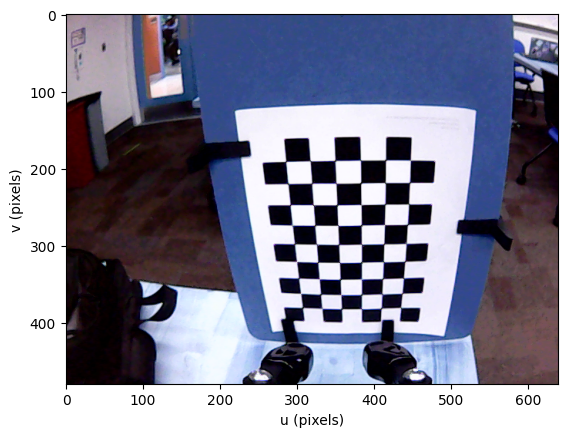

In [2]:
images = ImageCollection("calibration_imgs/*.png")

id = 2
images[id].disp() 

**Step 3:**

Compute the calibration results: camera intrinsic parameters (K), distortion, image frames

In [3]:
K, distortion, frames = CentralCamera.images2C(images, gridshape=(9, 6), squaresize=24e-3)

print(f'The intrinsic matrix, K: \n{K} \n')
print(f'The distortion parameters: \n{distortion} \n')

The intrinsic matrix, K: 
[[   531.2        0    354.2]
 [       0    531.5      219]
 [       0        0        1]] 

The distortion parameters: 
[ -0.5151    0.043 0.006304 9.856e-05    1.197] 



Note the distinction between the image center and the image principal point

In [4]:
print(f'The image center is at {images[0].center}')
print(f'The image principal point is at {K[0:2,2]}')

The image center is at (319.5, 239.5)
The image principal point is at [   354.2      219]


In [ ]:
# TODO: Display one of the image frames with the calibration corners drawn

#  frames[id].image.disp()

In [ ]:
# TODO: Display the estimated pose of the camera relative to each of the calibration images

# for frame in frames:
#     CentralCamera.plot(pose=frame.pose, scale=0.03)

**Step 4:**

Apply the intrinsic parameters and the lens distortion parameters to undistort the image

In [ ]:
# TODO: Extract the intrinsic parameters

# u0 = K[0,2]
# v0 = ??
# fpixel_width = ??
# fpixel_height = ??


# TODO: Extract the lens distortion parameters

# k1, k2, p1, p2, k3 = distortion

In [ ]:
# TODO: Convert from pixel coordinates (u, v) to image plane coordinates (x, y)

# U, V = images[id].meshgrid()

# x = (U - u0) / fpixel_width
# y = (V - v0) / fpixel_height


# TODO: Calculate the radial distance of pixels from the principal point

# r = np.sqrt(x**2 + y**2)

In [ ]:
# TODO: Compute the image coordinate errors due to both radial and tangential distortion

# delta_x = x * (k1*r**2 + k2*r**4 + k3*r**6) + 2*p1*x*y + p2*(r**2 + 2*x**2)
# delta_y = y * (k1*r**2 + k2*r**4 + k3*r**6) + p1*(r**2 + 2*y**2) + p2*x*y

# TODO: distorted retinal coordinates

# xd = x + delta_x 
# yd = y + delta_y

# TODO: convert back from image coordinates to pixel coordinates in the distorted image

# Ud = xd * fpixel_width + u0
# Vd = yd * fpixel_height + v0

In [ ]:
# TODO: Apply the warp to a distorted image and observe the undistorted image

# undistorted_img = images[id].warp(Ud, Vd)
# undistorted_img.disp()
# images[id].disp()

**Extra Step:**

To obtain the camera extrinsic parameters (i.e., the position and orientation of the camera frame in a world frame), we can use the known positions of the checkerboard corners and the intrinsic parameters and distortion as follows.

The **goal of this code** is to compute the pose (position and orientation) and draw a 3D reference frame at the "origin" corner of the checkerboard.

In [ ]:
def draw(img, corners, imgpts):
    """ TBD """
    corner = tuple(corners[0].ravel().astype("int32"))
    imgpts = imgpts.astype("int32")
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [ ]:
# add
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# add
objpoints = np.zeros((9*6,3), np.float32)
objpoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# add
axis = np.float32([[2,0,0], [0,2,0], [0,0,-2]]).reshape(-1,3)

In [ ]:
# Get the undistorted and convert to grayscale
img = np.array(undistorted_img.bgr, dtype=np.uint8)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# Find checkerboard corners in pixel coordinates
ret, corners = cv.findChessboardCorners(gray, (9,6),None) 

if ret == True:
    # Refine the corner positions in pixel coordinates
    corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    
    # Given the known relative positions between objpoints and the corners2 (in pixels), 
    # find the rotation and translation between the checkerboard and the camera frame
    ret, rvecs, tvecs = cv.solvePnP(objpoints, corners2, K, distortion)
    
    # project 3D points to image plane
    imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, K, distortion)

    img = draw(img,corners2,imgpts)
    plt.imshow(img)

print(f"Rotation vector: \n{rvecs}")
print(f"Translation vector: \n{tvecs}")

In [ ]:
# Convert the rotation vector to a rotation matrix using Rodrigues
R, _ = cv.Rodrigues(rvecs)

# Combine the 3x3 rotation matrix and the 3x1 translation vector to compute
# the 4x4 camera transformation matrix
T = np.hstack((R, tvecs.reshape(3, 1)))

print(f"Camera transformation matrix, T: \n{T}")

**Practice Exercise:**

To build some intuition about the transformations between world, to camera to image to pixel coordinates and back, work on this exercise using the parameters we have computed.

In [ ]:
# TODO: Imagine an object at point (1.0, 0.0, 0.0), i.e., at one unit in the x-axis in the world frame
# in our case, the reference frame of the checkerboard.
obj_world = np.array([1, 0, 0, 1.0])

# TODO: Project this object from the world frame to the camera frame using T
# obj_camera = ??
# print(f"Object coordinate in the Camera Frame: {obj_camera[:3]}")

In [ ]:
# TODO: Project the object from the 3D camera coordinates to the 2D image plane (in pixel coordinates) using K
# obj_image = ??

# TODO: Normalize by the z-coordinate to get homogeneous coordinates
# obj_image = ??

# print(f"2D pixel coordinates: {obj_image}")

In [ ]:
# TODO: Verify the transformations by drawing the object in the checkerboard and verifying the pixel coordinates

# # Draw a circle at the 2D pixel coordinates
# color = (200,100,200)
# obj_pixel = (int(obj_image[0]), int(obj_image[1]))
# cv.circle(img, obj_pixel, radius=6, color=color, thickness=-1)

# # Draw the trace lines
# cv.line(img, obj_pixel, (obj_pixel[0], 480), color, 1) # u axis
# cv.line(img, obj_pixel, (0, obj_pixel[1]), color, 1) # v axis

# plt.imshow(img)

### 2. Object pose estimation using ArUco markers

**Step 1:** 

Use the **camera_capture.py** script to capture an image of the ArUco marker. Note where the image files are stored. See image below for example:

<img src="img\ex-aruco-cubes.png" width="500">

**Step 2:**

Import the frame and then detect and perform pose estimation on the aruco markers in the frame.

In [ ]:
# Import the image frame stored from step 1
scene = Image.Read("img/aruco-cubes.png", rgb=False)
scene.disp()

In [ ]:
# TODO: Undistort the frame using the parameters derived during calibration

# undistorted_scene = scene.warp(Ud, Vd)
# undistorted_scene.disp()

In [ ]:
# TODO: Detect and estimate pose of the markers in the frame
# N.B.: the dictionary of the specific AruCo marker used, its size and the camera intrinsic parameters
# are required

# markers = undistorted_scene.fiducial(dict="36h11", K=K, side=25e-3)

# for marker in markers:
#     print(marker)

In [ ]:
# TODO: draw the pose frame in the image

# for marker in markers:
#   marker.draw(undistorted_scene, length=0.03, thick=3)
# undistorted_scene.disp()

### 3. Object pose estimation using ArUco board

The reason we might want to do this is to avoid needing to attach markers on individual objects in our operating space and use their relative pose to the AruCo board to estimate their pose with respect to the camera frame.

**Step 1:**

Use the **camera_capture.py** script to capture an image of the ArUco board with NO objects on it. Note where the image files are stored. See image below for example:

<img src="img\ex-aruco-board.png" width="500">

**Step 2:**

Import the frame and then detect and perform pose estimation on the aruco board to determine the pose of the reference frame of the board.

In [ ]:
scene = Image.Read("img/aruco-board.png", rgb=False)
scene.disp()

In [ ]:
# TODO: Undistort the frame using the parameters derived during calibration

# undistorted_scene = scene.warp(Ud, Vd)
# undistorted_scene.disp()

In [ ]:
# TODO: Define the aruco board object
# N.B. take note of the parameters here

# gridshape = (5, 7)
# square_size = 28e-3
# spacing_size = 3e-3
# board = ArUcoBoard(gridshape, square_size, spacing_size, dict="6x6_1000", firsttag=0)

In [ ]:
# TODO: Use the calibration parameters to create a calibrated camera object

# C = np.column_stack((K, np.array([0, 0, 1]))) # camera matrix
# est = CentralCamera.decomposeC(C)

# camera = CentralCamera(f=est.f[0], rho=est.rho[0], imagesize=[480, 640], pp=est.pp)

In [ ]:
# TODO: estimate the pose of the board frame wrt the camera frame

# board.estimatePose(undistorted_scene, camera)

In [ ]:
# board.draw(undistorted_scene, camera, length=0.05, thick=4)
# undistorted_scene.disp()

**Step 3:**

Follow the same steps as in **Step 2**, but in this case, place objects you would like to interact with on the board as in the image below.

<img src="img\ex-aruco-board-cubes.png" width="500">

The idea here is that you should be able to still determine the pose of the board frame (at the board origin) with respect to the camera frame and then using color-based image processing you can determine position (and possibly the orientation) of the target objects relative to the board (**this is intentionally vague as I want you to think deeply about this!**)